**Time Series 2017**
<br/>Run ARIMA and FacebookProphet models on the 2017 Burbank data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
%matplotlib inline

from statsmodels.api import tsa
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from math import sqrt

from fbprophet import Prophet

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# increase display size to enable viewing of all data columns

pd.options.display.max_columns = 40

In [4]:
# read in the 2017 burbank csv

burbank2017comp_df = pd.read_csv('burbank2017comp.csv', index_col=0)
burbank2017comp_df

,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Origin,OriginCityName,OriginState,Dest,DestCityName,DestState,CRSDepTime,DepTime,DepDelay,DepDel15,DepartureDelayGroups,TaxiOut,WheelsOff,Cancelled,CancellationCode,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSArrTime,ArrTime,ArrDelay,Delayed
163,6,2017-07-01,AS,N520AS,BUR,"Burbank, CA",CA,SEA,"Seattle, WA",WA,700,708.0,8.0,0.0,0.0,13.0,721.0,0,0,937,4,0.0,0.0,0.0,0.0,0.0,930,942.0,12.0,1
340,6,2017-07-01,AS,N563AS,BUR,"Burbank, CA",CA,SEA,"Seattle, WA",WA,1730,1720.0,-10.0,0.0,-1.0,22.0,1742.0,0,0,937,4,0.0,0.0,0.0,0.0,0.0,1958,2010.0,12.0,1
367,6,2017-07-01,AS,N562AS,BUR,"Burbank, CA",CA,SEA,"Seattle, WA",WA,1215,1212.0,-3.0,0.0,-1.0,22.0,1234.0,0,0,937,4,0.0,0.0,16.0,0.0,0.0,1443,1459.0,16.0,1
699,7,2017-07-02,AS,N530AS,BUR,"Burbank, CA",CA,SEA,"Seattle, WA",WA,700,657.0,-3.0,0.0,-1.0,14.0,711.0,0,0,937,4,0.0,0.0,0.0,0.0,0.0,930,941.0,11.0,1
882,7,2017-07-02,AS,N527AS,BUR,"Burbank, CA",CA,SEA,"Seattle, WA",WA,1730,1721.0,-9.0,0.0,-1.0,13.0,1734.0,0,0,937,4,0.0,0.0,0.0,0.0,0.0,1958,1947.0,-11.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5671663,2,2017-09-19,UA,N36207,BUR,"Burbank, CA",CA,SFO,"San Francisco, CA",CA,708,706.0,-2.0,0.0,-1.0,32.0,738.0,0,0,326,2,0.0,0.0,0.0,0.0,0.0,833,841.0,8.0,1
5672027,2,2017-09-19,UA,N836UA,BUR,"Burbank, CA",CA,SFO,"San Francisco, CA",CA,2015,2000.0,-15.0,0.0,-1.0,18.0,2018.0,0,0,326,2,0.0,0.0,0.0,0.0,0.0,2141,2125.0,-16.0,0
5672145,2,2017-09-19,UA,N14240,BUR,"Burbank, CA",CA,DEN,"Denver, CO",CO,700,651.0,-9.0,0.0,-1.0,26.0,717.0,0,0,850,4,0.0,0.0,0.0,0.0,0.0,1029,1012.0,-17.0,0
5673747,2,2017-09-05,UA,N78285,BUR,"Burbank, CA",CA,SFO,"San Francisco, CA",CA,1220,1214.0,-6.0,0.0,-1.0,10.0,1224.0,0,0,326,2,0.0,0.0,0.0,0.0,0.0,1339,1319.0,-20.0,0


In [5]:
# create a dataframe of the flights originating in Burbank containing only the data and departure delay times

burbank2017_df = burbank2017comp_df[['FlightDate', 'DepDelay', 'CRSDepTime']]
burbank2017_df

,FlightDate,DepDelay,CRSDepTime
163,2017-07-01,8.0,700
340,2017-07-01,-10.0,1730
367,2017-07-01,-3.0,1215
699,2017-07-02,-3.0,700
882,2017-07-02,-9.0,1730
...,...,...,...
5671663,2017-09-19,-2.0,708
5672027,2017-09-19,-15.0,2015
5672145,2017-09-19,-9.0,700
5673747,2017-09-05,-6.0,1220


In [6]:
# split the date column into year, month and day components

burbank2017_df['Year'] = pd.DatetimeIndex(burbank2017_df['FlightDate']).year
burbank2017_df['Month'] = pd.DatetimeIndex(burbank2017_df['FlightDate']).month
burbank2017_df['Day'] = pd.DatetimeIndex(burbank2017_df['FlightDate']).day
burbank2017_df.drop(['FlightDate'], axis=1, inplace=True)
burbank2017_df

,DepDelay,CRSDepTime,Year,Month,Day
163,8.0,700,2017,7,1
340,-10.0,1730,2017,7,1
367,-3.0,1215,2017,7,1
699,-3.0,700,2017,7,2
882,-9.0,1730,2017,7,2
...,...,...,...,...,...
5671663,-2.0,708,2017,9,19
5672027,-15.0,2015,2017,9,19
5672145,-9.0,700,2017,9,19
5673747,-6.0,1220,2017,9,5


In [7]:
# separate the CRSDepTime into hour and minute components

burbank2017_df['CRSDepTime'] = burbank2017_df['CRSDepTime'].astype(str)
burbank2017_df['Length'] = burbank2017_df['CRSDepTime'].str.len()

burbank2017_df.loc[burbank2017_df['Length'] == 3, 'Hour'] = burbank2017_df['CRSDepTime'].astype(str).str[0:1]
burbank2017_df.loc[burbank2017_df['Length'] == 4, 'Hour'] = burbank2017_df['CRSDepTime'].astype(str).str[0:2]

burbank2017_df.loc[burbank2017_df['Length'] == 3, 'Minute'] = burbank2017_df['CRSDepTime'].astype(str).str[1:3]
burbank2017_df.loc[burbank2017_df['Length'] == 4, 'Minute'] = burbank2017_df['CRSDepTime'].astype(str).str[2:4]

burbank2017_df.drop(['CRSDepTime',
                     'Length'], axis=1, inplace=True)

burbank2017_df

,DepDelay,Year,Month,Day,Hour,Minute
163,8.0,2017,7,1,7,00
340,-10.0,2017,7,1,17,30
367,-3.0,2017,7,1,12,15
699,-3.0,2017,7,2,7,00
882,-9.0,2017,7,2,17,30
...,...,...,...,...,...,...
5671663,-2.0,2017,9,19,7,08
5672027,-15.0,2017,9,19,20,15
5672145,-9.0,2017,9,19,7,00
5673747,-6.0,2017,9,5,12,20


In [8]:
# set the time related values to strings

burbank2017_df['Year'] = burbank2017_df['Year'].astype(str)
burbank2017_df['Month'] = burbank2017_df['Month'].astype(str)
burbank2017_df['Day'] = burbank2017_df['Day'].astype(str)
burbank2017_df['Hour'] = burbank2017_df['Hour'].astype(str)
burbank2017_df['Minute'] = burbank2017_df['Minute'].astype(str)
burbank2017_df.dtypes

DepDelay    float64
Year         object
Month        object
Day          object
Hour         object
Minute       object
dtype: object

In [9]:
# add the time related strings together into proper format

burbank2017_df['TimeString'] = burbank2017_df['Year'] + '-' + burbank2017_df['Month'] + '-' + burbank2017_df['Day'] + ' ' + burbank2017_df['Hour'] \
                    + ':' + burbank2017_df['Minute'] + ':00'             
burbank2017_df

,DepDelay,Year,Month,Day,Hour,Minute,TimeString
163,8.0,2017,7,1,7,00,2017-7-1 7:00:00
340,-10.0,2017,7,1,17,30,2017-7-1 17:30:00
367,-3.0,2017,7,1,12,15,2017-7-1 12:15:00
699,-3.0,2017,7,2,7,00,2017-7-2 7:00:00
882,-9.0,2017,7,2,17,30,2017-7-2 17:30:00
...,...,...,...,...,...,...,...
5671663,-2.0,2017,9,19,7,08,2017-9-19 7:08:00
5672027,-15.0,2017,9,19,20,15,2017-9-19 20:15:00
5672145,-9.0,2017,9,19,7,00,2017-9-19 7:00:00
5673747,-6.0,2017,9,5,12,20,2017-9-5 12:20:00


In [10]:
# change the time string into datetime format, and drop columns no longer needed

burbank2017_df['Time'] = pd.to_datetime(burbank2017_df['TimeString'])
burbank2017_df.drop(['Year',
                     'Month',
                     'Day',
                     'Hour',
                     'Minute',
                     'TimeString'], axis=1, inplace=True)
burbank2017_df.head()

,DepDelay,Time
163,8.0,2017-07-01 07:00:00
340,-10.0,2017-07-01 17:30:00
367,-3.0,2017-07-01 12:15:00
699,-3.0,2017-07-02 07:00:00
882,-9.0,2017-07-02 17:30:00


In [11]:
# reorder the columns

burbank2017_df = burbank2017_df[['Time', 'DepDelay']]
burbank2017_df

,Time,DepDelay
163,2017-07-01 07:00:00,8.0
340,2017-07-01 17:30:00,-10.0
367,2017-07-01 12:15:00,-3.0
699,2017-07-02 07:00:00,-3.0
882,2017-07-02 17:30:00,-9.0
...,...,...
5671663,2017-09-19 07:08:00,-2.0
5672027,2017-09-19 20:15:00,-15.0
5672145,2017-09-19 07:00:00,-9.0
5673747,2017-09-05 12:20:00,-6.0


In [12]:
#create buckets of time based on departure delay

burbank2017_df['DelayDesc'] = 'new'
burbank2017_df.loc[(burbank2017_df['DepDelay'] <= 0), 'DelayDesc'] = '0-'
burbank2017_df.loc[(burbank2017_df['DepDelay'] > 0) & (burbank2017_df['DepDelay'] <= 60), 'DelayDesc'] = '1-60'
burbank2017_df.loc[burbank2017_df['DepDelay'] > 60, 'DelayDesc'] = '61+'

burbank2017_df['DelayDesc'].value_counts()

0-      15217
1-60     8533
61+      1355
Name: DelayDesc, dtype: int64

In [13]:
# create a dataframe excluding outliers

moderate2017_df = burbank2017_df[(burbank2017_df['DelayDesc'] != '61+')]
moderate2017_df.drop('DelayDesc', axis=1, inplace=True)
moderate2017_df.sort_values(by=['Time'], inplace=True)
moderate2017_df

,Time,DepDelay
3750091,2017-01-01 06:49:00,-18.0
3662543,2017-01-01 07:00:00,-8.0
3662531,2017-01-01 07:05:00,-2.0
3750967,2017-01-01 07:05:00,-10.0
3750505,2017-01-01 07:10:00,-14.0
...,...,...
1037958,2017-12-31 18:40:00,10.0
1310849,2017-12-31 19:25:00,8.0
1310841,2017-12-31 19:55:00,-5.0
1162694,2017-12-31 20:35:00,-14.0


In [14]:
# create a dataframe excluding outliers, just for the month on january

jan2017_df = moderate2017_df[(pd.DatetimeIndex(moderate2017_df['Time']).month == 1)]
jan2017_df.reset_index(inplace=True, drop=True)
jan2017_df

,Time,DepDelay
0,2017-01-01 06:49:00,-18.0
1,2017-01-01 07:00:00,-8.0
2,2017-01-01 07:05:00,-2.0
3,2017-01-01 07:05:00,-10.0
4,2017-01-01 07:10:00,-14.0
...,...,...
1811,2017-01-31 20:55:00,-2.0
1812,2017-01-31 20:58:00,-11.0
1813,2017-01-31 21:20:00,-2.0
1814,2017-01-31 21:29:00,14.0


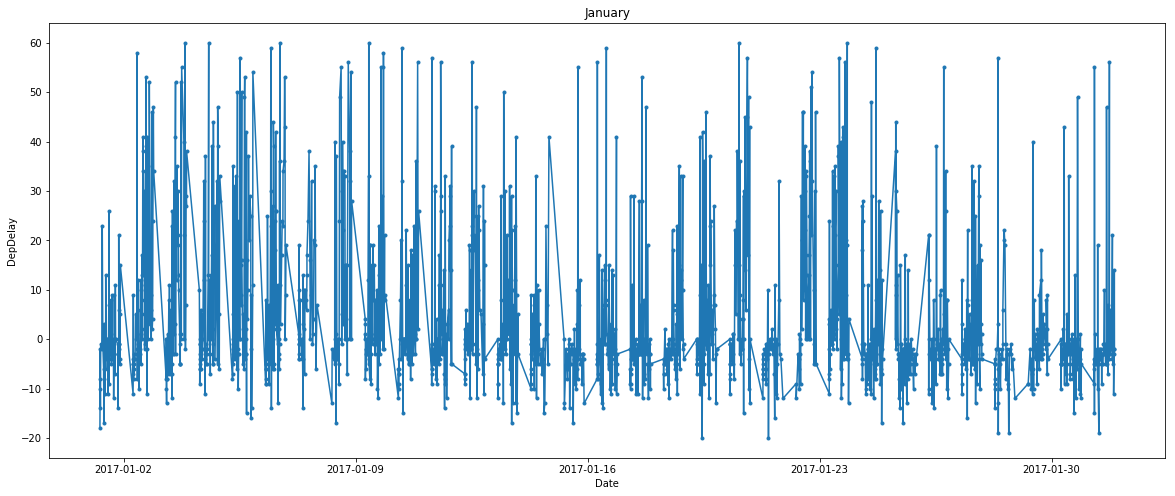

In [15]:
plt.rcParams['figure.figsize'] = (20, 8)

plt.figure()
plt.plot(jan2017_df['Time'], jan2017_df['DepDelay'], marker='.')
plt.xlabel('Date')
plt.ylabel('DepDelay')
plt.title('January')
plt.show();

Can see from this the data is stationary (i.e. the probability distributions are stable over time).

In [16]:
# create a dataframe excluding outliers, just for the first week on january

weekone2017_df = jan2017_df[(pd.DatetimeIndex(jan2017_df['Time']).day <= 7)]
weekone2017_df

,Time,DepDelay
0,2017-01-01 06:49:00,-18.0
1,2017-01-01 07:00:00,-8.0
2,2017-01-01 07:05:00,-2.0
3,2017-01-01 07:05:00,-10.0
4,2017-01-01 07:10:00,-14.0
...,...,...
409,2017-01-07 17:50:00,20.0
410,2017-01-07 18:25:00,19.0
411,2017-01-07 18:40:00,35.0
412,2017-01-07 19:15:00,-6.0


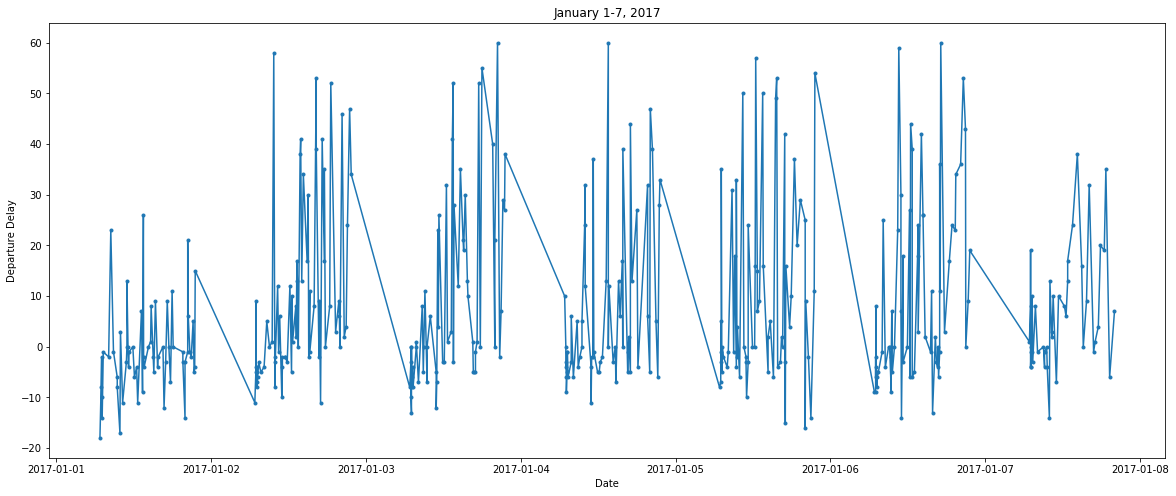

In [17]:
# plot departure delays over the first week of January

plt.figure()
plt.plot(weekone2017_df['Time'], weekone2017_df['DepDelay'], marker='.')
plt.xlabel('Date')
plt.ylabel('Departure Delay')
plt.title('January 1-7, 2017')
plt.show();

Looks like as each day goes on, flights get further behind schedule and then catch up overnight.

In [18]:
# create a dataframe excluding outliers, just for the second week on january

weektwo2017_df = jan2017_df[(pd.DatetimeIndex(jan2017_df['Time']).day > 7) & (pd.DatetimeIndex(jan2017_df['Time']).day <= 14)]
weektwo2017_df

,Time,DepDelay
414,2017-01-08 06:49:00,-13.0
415,2017-01-08 07:00:00,-2.0
416,2017-01-08 08:05:00,-4.0
417,2017-01-08 08:30:00,-2.0
418,2017-01-08 08:50:00,-5.0
...,...,...
791,2017-01-14 17:50:00,23.0
792,2017-01-14 18:25:00,7.0
793,2017-01-14 18:40:00,1.0
794,2017-01-14 19:15:00,-5.0


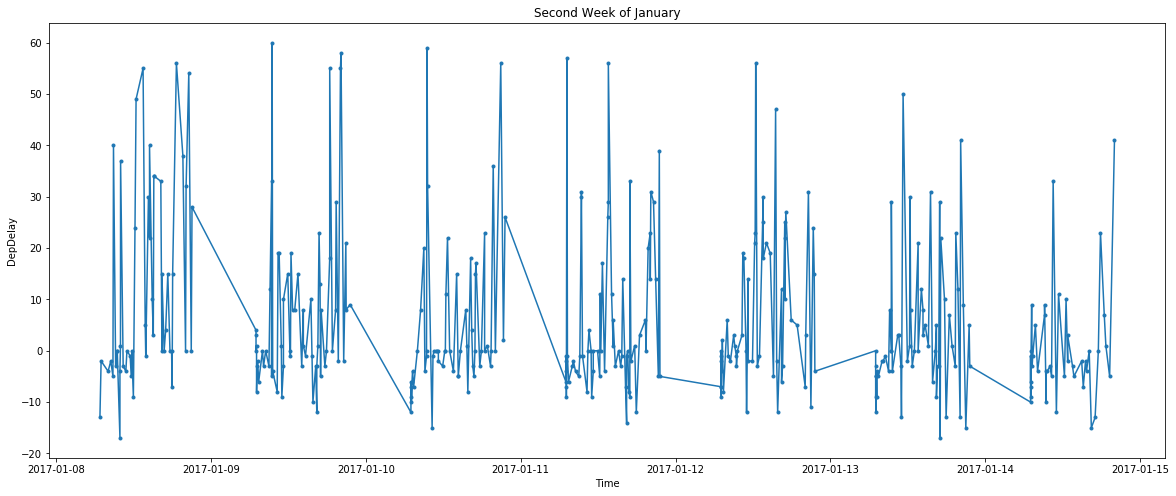

In [19]:
# plot departure delays over the second week of January

plt.figure()
plt.plot(weektwo2017_df['Time'], weektwo2017_df['DepDelay'], marker='.')
plt.xlabel('Time')
plt.ylabel('DepDelay')
plt.title('Second Week of January')
plt.show();

In [20]:
# drop the DelayDesc column and set the Time column as the index

burbank2017_df.drop('DelayDesc', axis=1, inplace=True)
burbank2017_df.sort_values(by=['Time'], inplace=True)
burbank2017_df.set_index('Time', inplace=True)
burbank2017_df

,DepDelay
Time,
2017-01-01 06:49:00,-18.0
2017-01-01 07:00:00,106.0
2017-01-01 07:00:00,-8.0
2017-01-01 07:05:00,-10.0
2017-01-01 07:05:00,-2.0
...,...
2017-12-31 19:25:00,8.0
2017-12-31 19:55:00,-5.0
2017-12-31 20:25:00,164.0


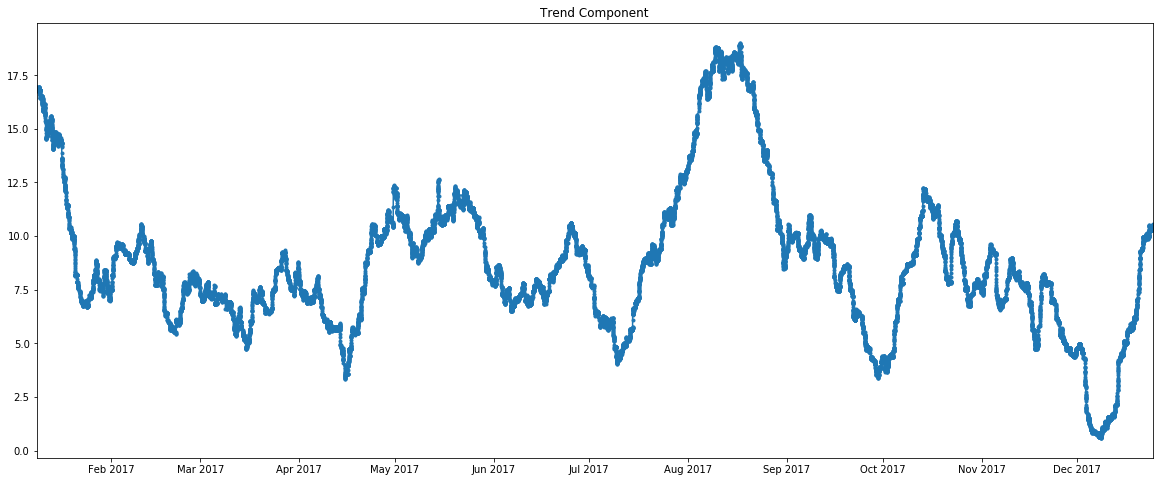

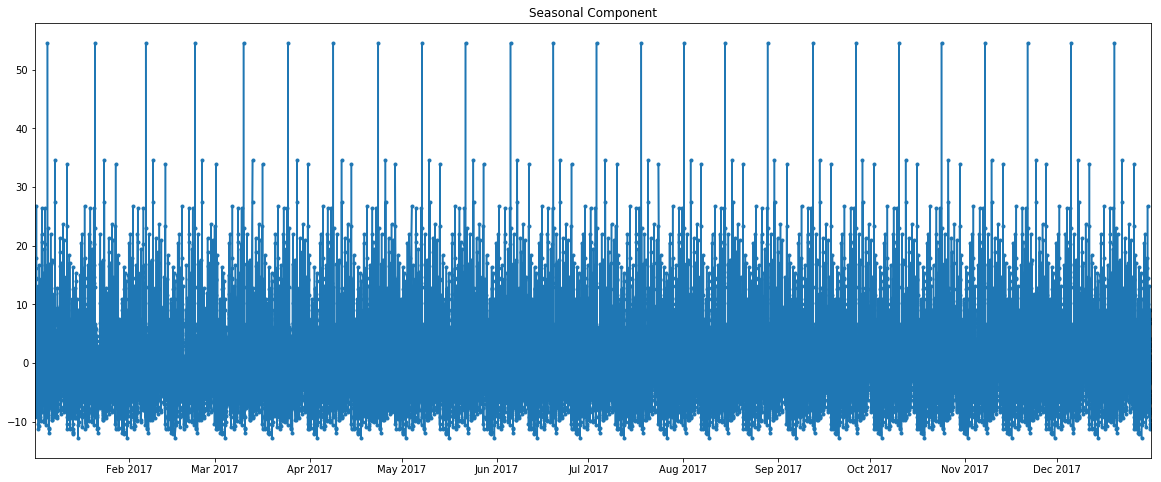

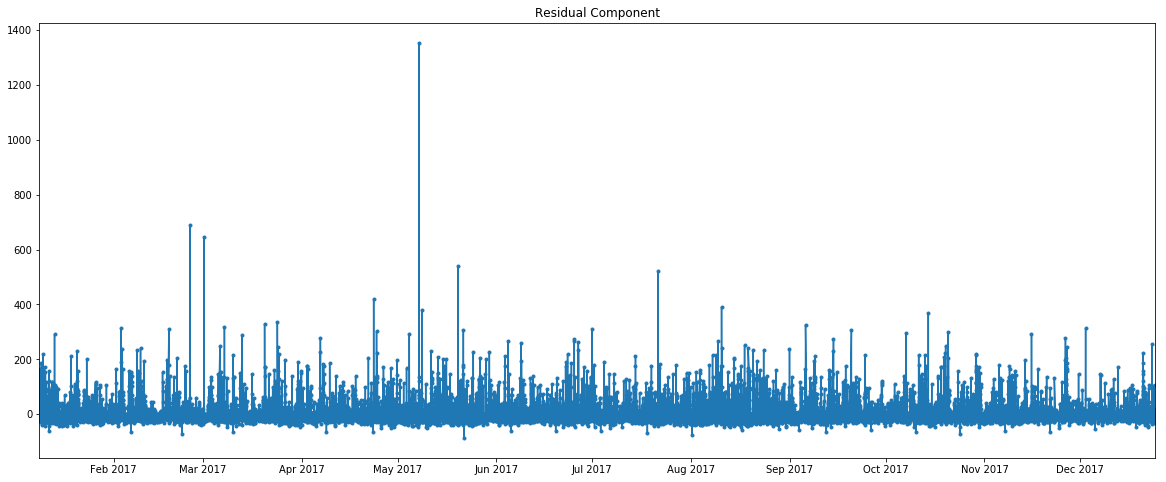

In [21]:
# decompose the time series
decompose2017 = tsa.seasonal_decompose(burbank2017_df, model='additive', freq=1000)

# trend
plt.figure()
ax = plt.gca()
plt.plot(decompose2017.trend, marker='.')
plt.title('Trend Component')
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.show();

# seasonal component
plt.figure()
ax = plt.gca()
plt.plot(decompose2017.seasonal, marker='.')
plt.title('Seasonal Component')
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.show();

# residuals
plt.figure()
ax = plt.gca()
plt.plot(decompose2017.resid, marker='.')
plt.title('Residual Component')
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.show();

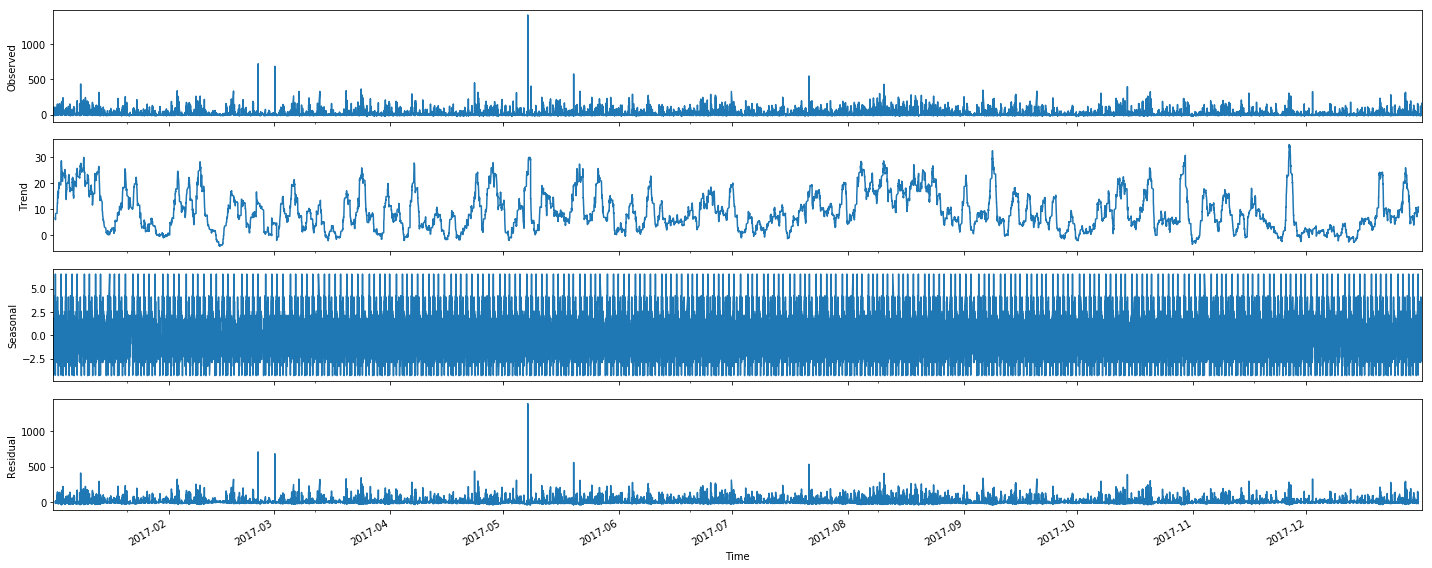

In [22]:
decompose2017 = tsa.seasonal_decompose(burbank2017_df, model='additive', freq=100)
decompose2017.plot()
plt.show();

In [23]:
# drop the DelayDesc column and set the Time column as the index

weekone2017_df.set_index('Time', inplace=True)
weekone2017_df

,DepDelay
Time,
2017-01-01 06:49:00,-18.0
2017-01-01 07:00:00,-8.0
2017-01-01 07:05:00,-2.0
2017-01-01 07:05:00,-10.0
2017-01-01 07:10:00,-14.0
...,...
2017-01-07 17:50:00,20.0
2017-01-07 18:25:00,19.0
2017-01-07 18:40:00,35.0


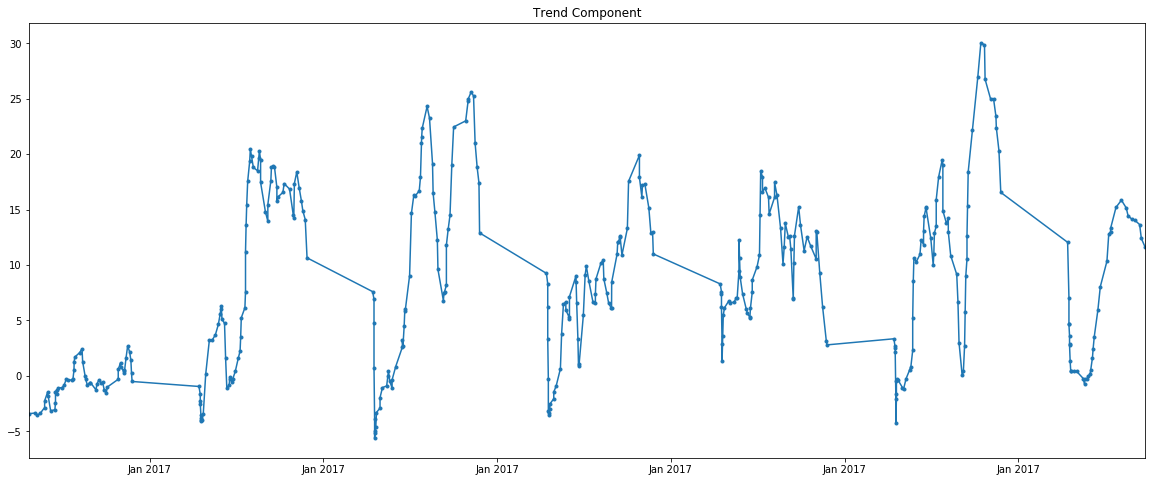

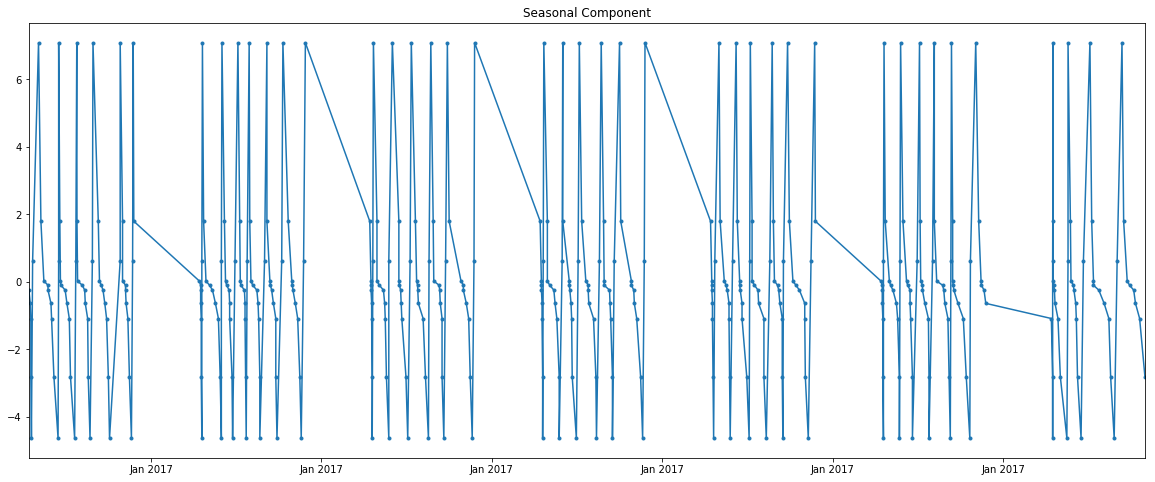

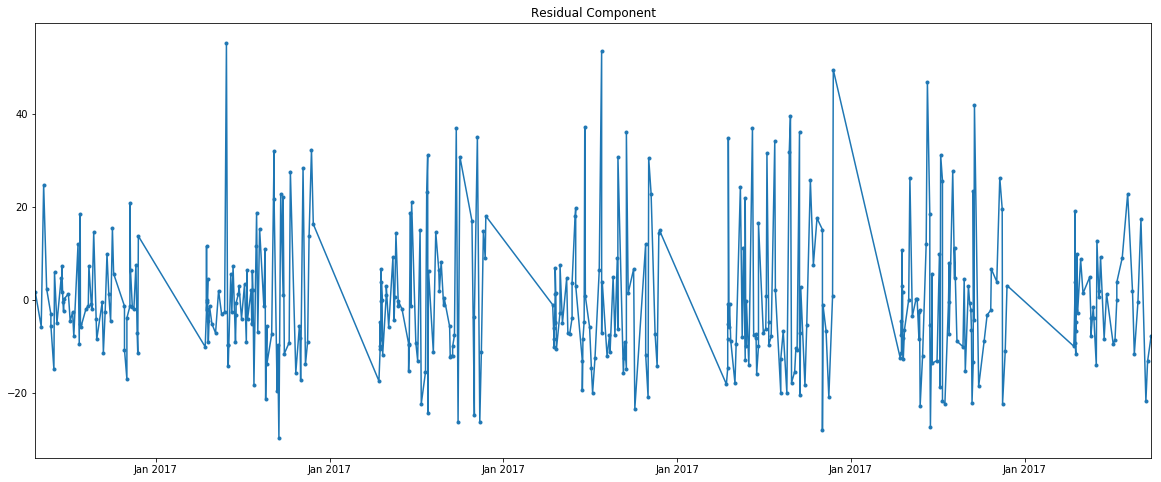

In [24]:
# decompose the time series
decompose2017 = tsa.seasonal_decompose(weekone2017_df, model='additive', freq=10)

# trend
plt.figure()
ax = plt.gca()
plt.plot(decompose2017.trend, marker='.')
plt.title('Trend Component')
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.show();

# seasonal component
plt.figure()
ax = plt.gca()
plt.plot(decompose2017.seasonal, marker='.')
plt.title('Seasonal Component')
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.show();

# residuals
plt.figure()
ax = plt.gca()
plt.plot(decompose2017.resid, marker='.')
plt.title('Residual Component')
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.show();

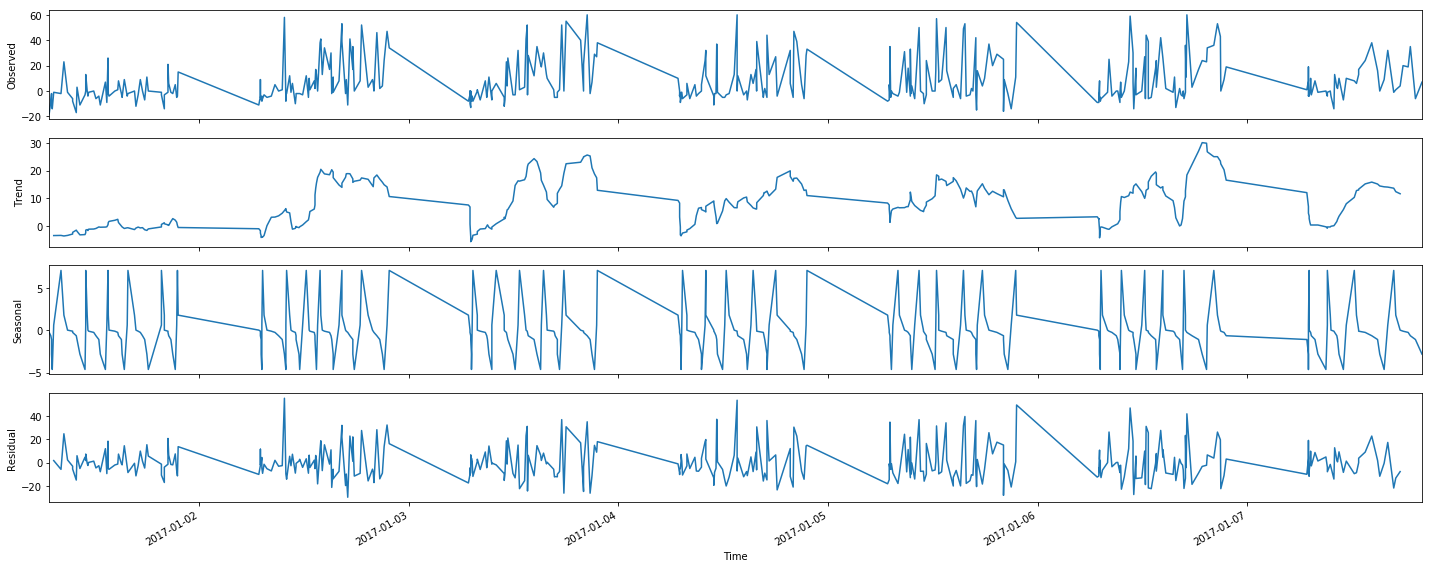

In [25]:
decompose2017 = tsa.seasonal_decompose(weekone2017_df, model='additive', freq=10)
decompose2017.plot()
plt.show();

In [26]:
# set the train and validation data

train = jan2017_df['DepDelay'][(pd.DatetimeIndex(jan2017_df['Time']).day >= 1 ) & (pd.DatetimeIndex(jan2017_df['Time']).day <= 5)]
validation = jan2017_df['DepDelay'][(pd.DatetimeIndex(jan2017_df['Time']).day >5) & (pd.DatetimeIndex(jan2017_df['Time']).day <= 7)]
print(train.shape)
print(validation.shape)

(308,)
(106,)


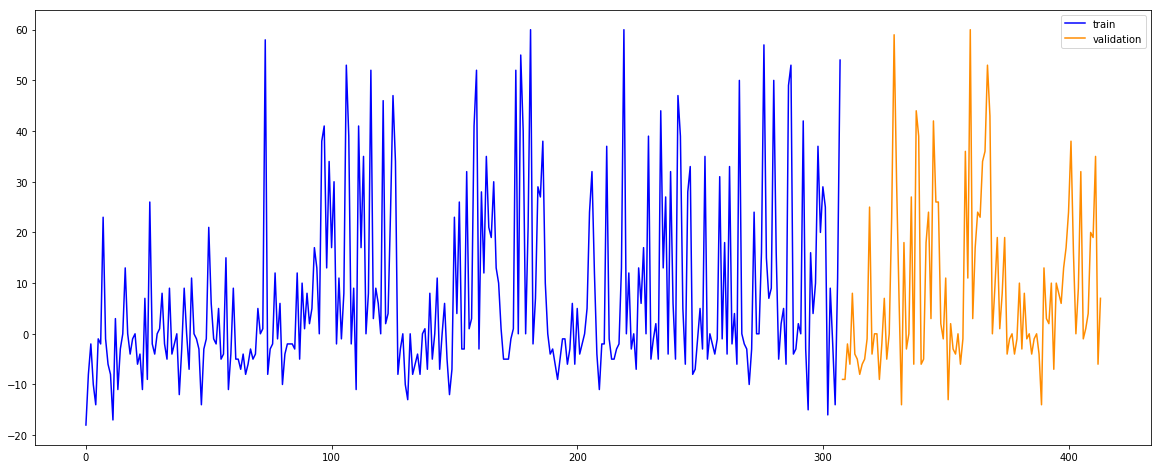

In [27]:
# plot the train and validation data

plt.figure()
plt.plot(list(range(0, len(train))), train, c="blue", label="train")
plt.plot(list(range(len(train), len(train)+len(validation))),validation, c="darkorange", label="validation")
plt.legend()
plt.show();

<Figure size 1440x576 with 0 Axes>

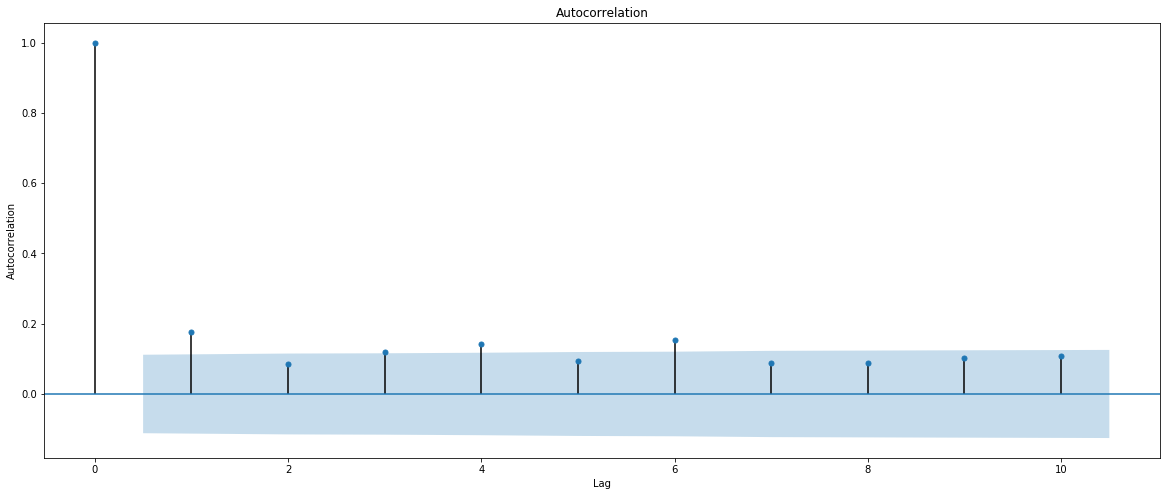

In [28]:
# plot the autocorrelation values

plt.figure()
plot_acf(train, lags=10)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show();

All low values - indicates there might not be enough information in past data points. Time Series might not be the best way to go.

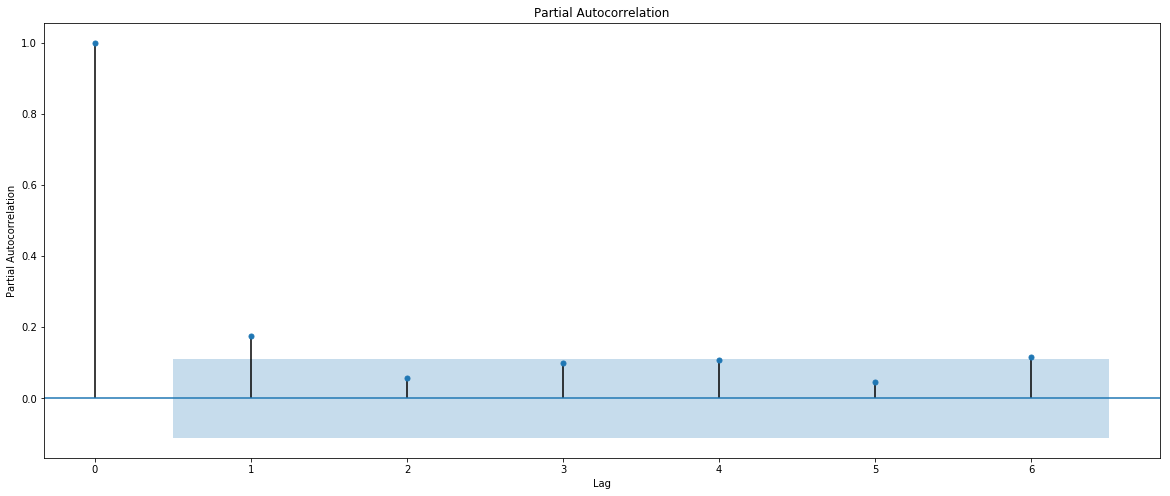

In [29]:
# plot the partial auto-correlation using a lag of 6 per the chart above

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train, lags=6)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show();

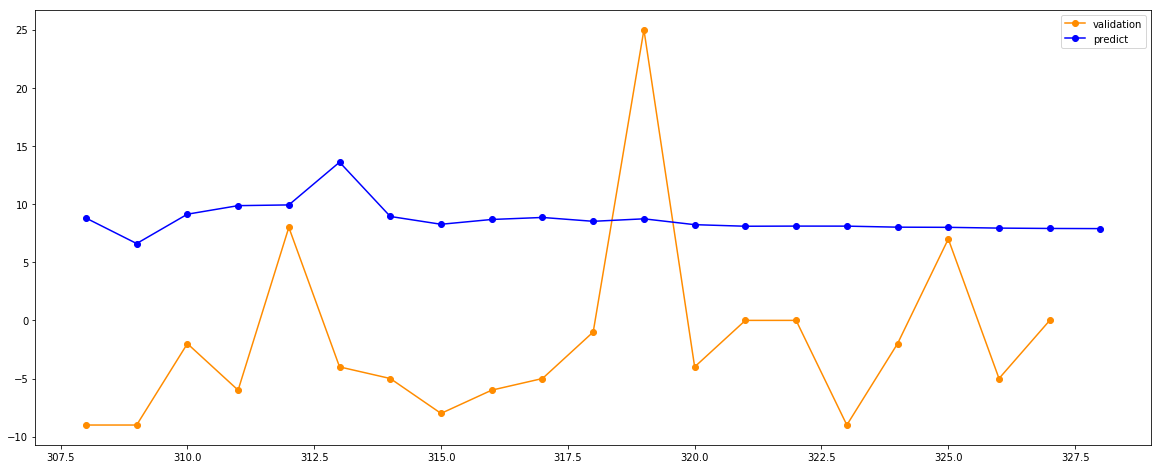

In [30]:
# fit and plot a basic autoregressive model

model = AR(train)
model_fit = model.fit(maxlag=6)

predictions = model_fit.predict(start=len(train), end=len(train)+20)

plt.figure()
plt.plot(validation[:20], c="darkorange", label="validation", marker='o')
plt.plot(predictions, c="blue", label="predict", marker='o')
plt.legend()
plt.show();

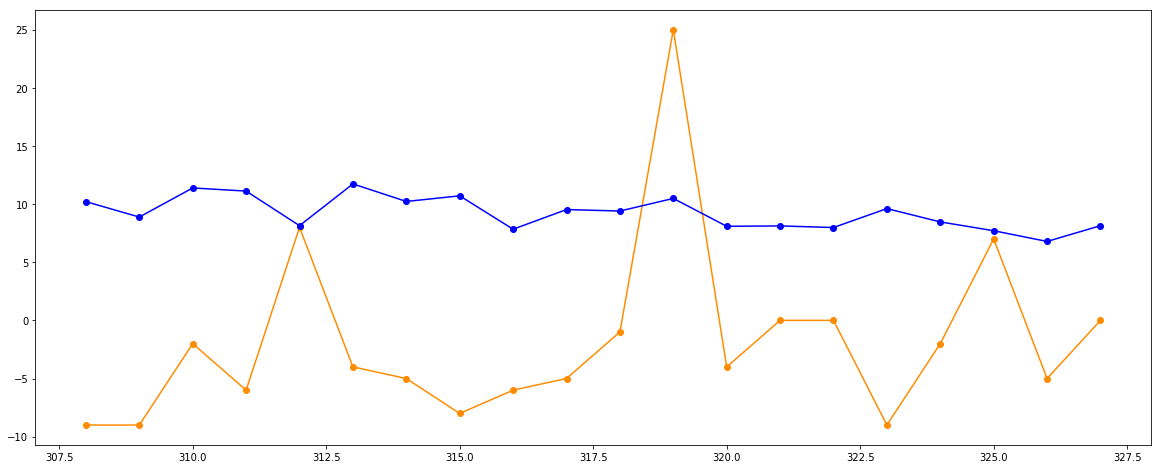

In [31]:
# try model with ARIMA

model = SARIMAX(train, order=(6,0,5), 
                enforce_stationarity=False, 
                enforce_invertibility=False)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(validation)-1, typ="levels")

plt.figure()
plt.plot(validation[:20], c="darkorange", label="validation", marker='o')
plt.plot(predictions[:20], c="blue", label="predict", marker='o')
plt.show();

In [32]:
# create new dataframe to be used with Facebook Prophet

train_df = jan2017_df[(pd.DatetimeIndex(jan2017_df['Time']).day >= 1 ) & (pd.DatetimeIndex(jan2017_df['Time']).day <= 21)]
train_df.rename(columns = {'Time' : 'ds', 'DepDelay' : 'y'}, inplace=True)
train_df

,ds,y
0,2017-01-01 06:49:00,-18.0
1,2017-01-01 07:00:00,-8.0
2,2017-01-01 07:05:00,-2.0
3,2017-01-01 07:05:00,-10.0
4,2017-01-01 07:10:00,-14.0
...,...,...
1203,2017-01-21 18:30:00,8.0
1204,2017-01-21 18:40:00,32.0
1205,2017-01-21 19:15:00,-3.0
1206,2017-01-21 20:00:00,-4.0


In [33]:
# fit a Facebook Prophet model

burbank_fp = Prophet(yearly_seasonality=True)
burbank_fp.fit(train_df)

In [34]:
# make future dataframe

future = burbank_fp.make_future_dataframe(periods=10)
future

,ds
0,2017-01-01 06:49:00
1,2017-01-01 07:00:00
2,2017-01-01 07:05:00
3,2017-01-01 07:05:00
4,2017-01-01 07:10:00
...,...
1213,2017-01-27 21:29:00
1214,2017-01-28 21:29:00
1215,2017-01-29 21:29:00
1216,2017-01-30 21:29:00


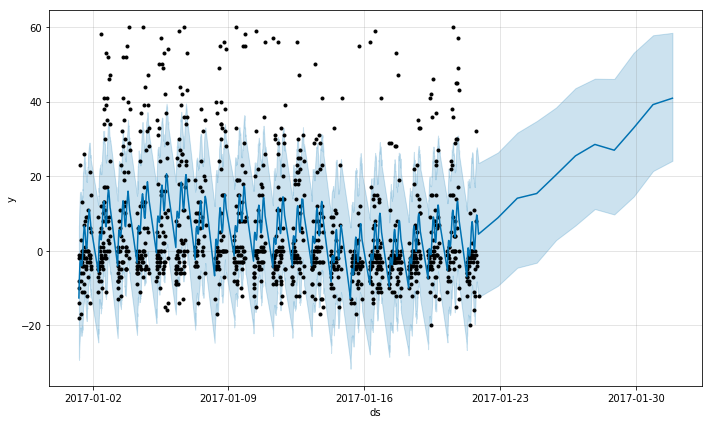

In [35]:
# predict qand plot the Facebook prophet forecast

forecast = burbank_fp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

january2017 = burbank_fp.plot(forecast)

After running inital models, it appears the flight data doesn't lend itself well to time series, carry on other modelling techniques.

In [36]:
# create a dataframe of the number of flights each day

burbanksum_df = burbank2017comp_df[(burbank2017comp_df['Delayed'] == 1)]

burbanksum_df = burbanksum_df.groupby('FlightDate').count()
burbanksum_df.reset_index(inplace=True)

perday_df = pd.DataFrame(columns=['Date', 'TtlFlights'])

perday_df['Date'] = burbanksum_df['FlightDate']
perday_df['TtlFlights'] = burbanksum_df['DayOfWeek']
perday_df

,Date,TtlFlights
0,2017-01-01,30
1,2017-01-02,43
2,2017-01-03,40
3,2017-01-04,39
4,2017-01-05,43
...,...,...
360,2017-12-27,46
361,2017-12-28,23
362,2017-12-29,30
363,2017-12-30,24


In [37]:
# create a dataframe of January

janday_df = perday_df[(pd.DatetimeIndex(perday_df['Date']).month == 1)]
janday_df.reset_index(inplace=True, drop=True)
janday_df.head()

,Date,TtlFlights
0,2017-01-01,30
1,2017-01-02,43
2,2017-01-03,40
3,2017-01-04,39
4,2017-01-05,43


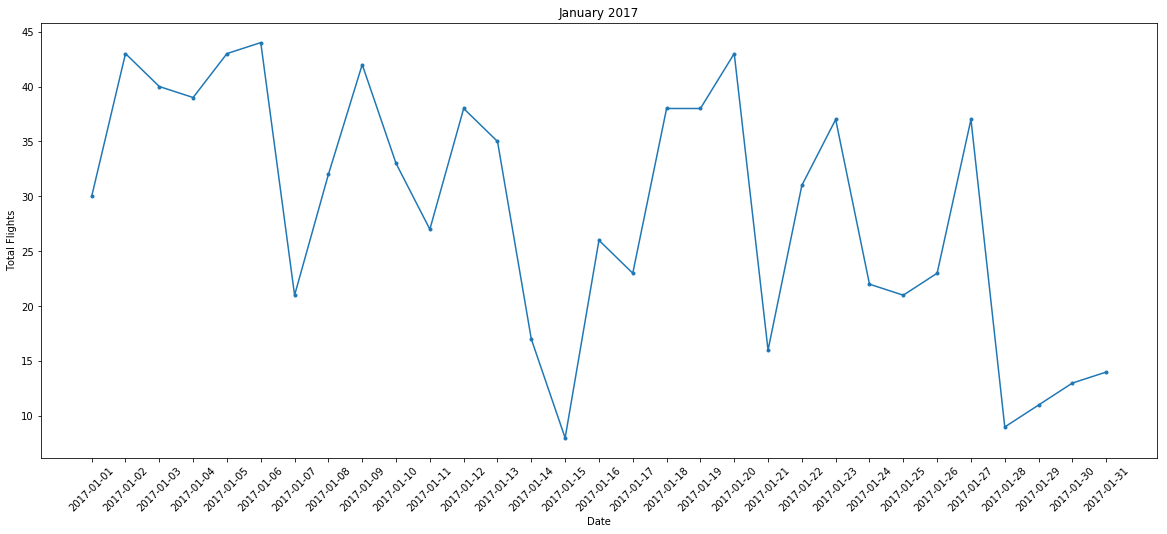

In [38]:
# plot the month of January

plt.figure()
plt.plot(janday_df['Date'], janday_df['TtlFlights'], marker='.')
plt.xlabel('Date')
plt.ylabel('Total Flights')
plt.title('January 2017')
plt.xticks(rotation=45)
plt.show();

In [39]:
# prepare the January dataframe for Facebook Prophet

janday_fp = janday_df[(pd.DatetimeIndex(janday_df['Date']).day >= 1 ) & (pd.DatetimeIndex(janday_df['Date']).day <= 21)]
janday_fp.rename(columns = {'Date' : 'ds', 'TtlFlights' : 'y'}, inplace=True)
janday_fp.head()

,ds,y
0,2017-01-01,30
1,2017-01-02,43
2,2017-01-03,40
3,2017-01-04,39
4,2017-01-05,43


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


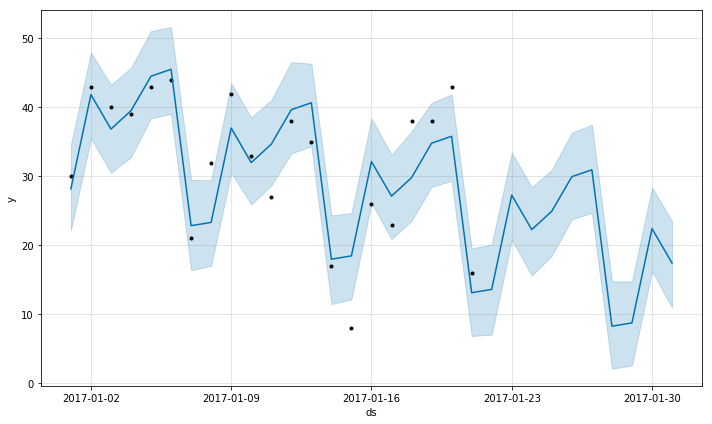

In [40]:
# fit a Facebook Prophet model

burbank_fp = Prophet(daily_seasonality=True)
burbank_fp.fit(janday_fp)

# make future dataframe

future = burbank_fp.make_future_dataframe(periods=10)

# predict qand plot the Facebook prophet forecast

forecast = burbank_fp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

january2017 = burbank_fp.plot(forecast)

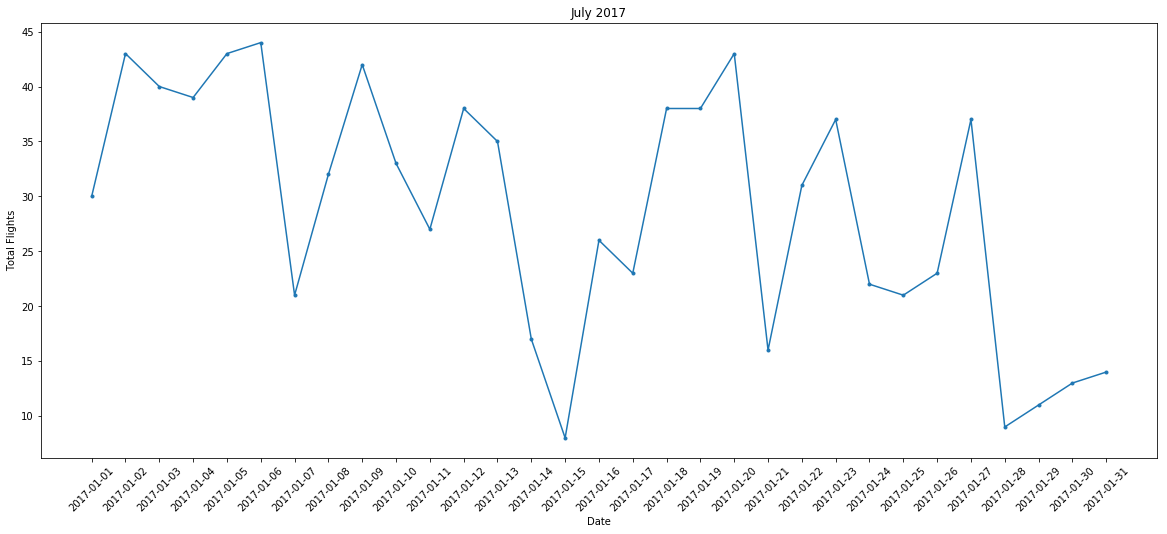

In [41]:
# compare Facebook Prophet predictions to 2017 actual data

plt.figure()
plt.plot(janday_df['Date'], janday_df['TtlFlights'], marker='.')
plt.xlabel('Date')
plt.ylabel('Total Flights')
plt.title('July 2017')
plt.xticks(rotation=45)
plt.show();

In [42]:
# create a dataframe of July delayed flights

julday_df = perday_df[(pd.DatetimeIndex(perday_df['Date']).month == 7)]
julday_df.reset_index(inplace=True, drop=True)


julday_fp = julday_df[(pd.DatetimeIndex(julday_df['Date']).day >= 1 ) & (pd.DatetimeIndex(julday_df['Date']).day <= 21)]
julday_fp.rename(columns = {'Date' : 'ds', 'TtlFlights' : 'y'}, inplace=True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


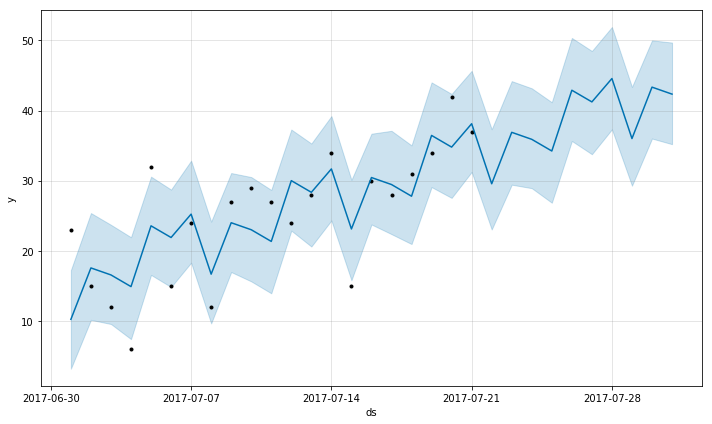

In [43]:
# fit a Facebook Prophet model

burbank_fp = Prophet(daily_seasonality=True)
burbank_fp.fit(julday_fp)

# make future dataframe

future = burbank_fp.make_future_dataframe(periods=10)

# predict qand plot the Facebook prophet forecast

forecast = burbank_fp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

july2017 = burbank_fp.plot(forecast)

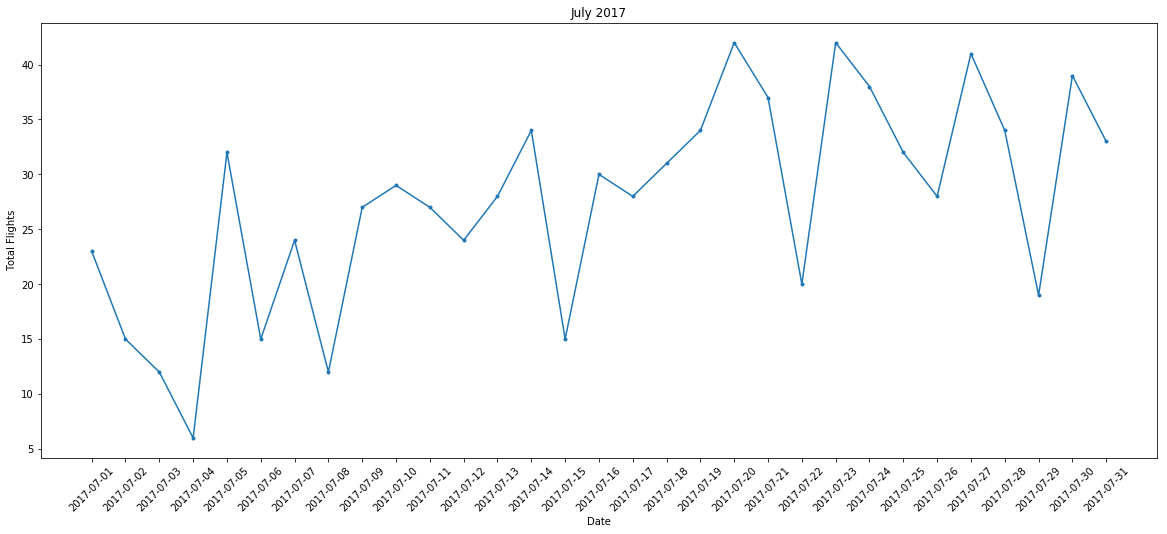

In [44]:
# compare Facebook Prophet predictions to 2017 actual data

plt.figure()
plt.plot(julday_df['Date'], julday_df['TtlFlights'], marker='.')
plt.xlabel('Date')
plt.ylabel('Total Flights')
plt.title('July 2017')
plt.xticks(rotation=45)
plt.show();

In [45]:
# create a dataframe of July delayed flights

allday_fp = perday_df[(pd.DatetimeIndex(perday_df['Date']).month >= 1 ) & (pd.DatetimeIndex(perday_df['Date']).month <= 10)]
allday_fp.rename(columns = {'Date' : 'ds', 'TtlFlights' : 'y'}, inplace=True)
allday_fp

,ds,y
0,2017-01-01,30
1,2017-01-02,43
2,2017-01-03,40
3,2017-01-04,39
4,2017-01-05,43
...,...,...
299,2017-10-27,24
300,2017-10-28,12
301,2017-10-29,37
302,2017-10-30,26


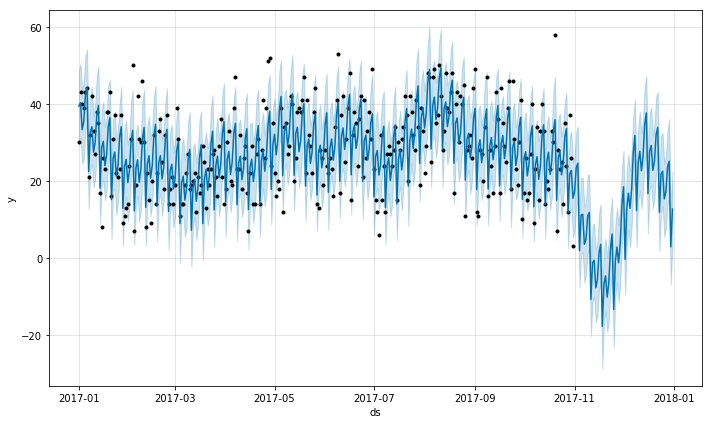

In [46]:
# fit a Facebook Prophet model

burbank_fp = Prophet(yearly_seasonality=True, daily_seasonality=True)
burbank_fp.fit(allday_fp)

# make future dataframe

future = burbank_fp.make_future_dataframe(periods=61)

# predict qand plot the Facebook prophet forecast

forecast = burbank_fp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

all2017 = burbank_fp.plot(forecast)

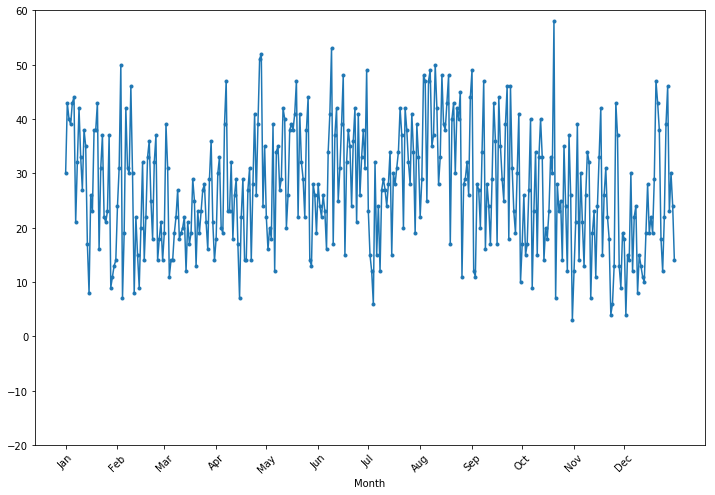

In [47]:
# compare the 2017 actual data against Facebook Prophet

plt.figure(figsize=(12,8))
plt.plot(perday_df['Date'], perday_df['TtlFlights'], marker='.')
plt.xlabel('Month')
plt.ylim((-20,60))
plt.xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334], 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
           rotation=20)
plt.xticks(rotation=45)
plt.show();